# Chromatin Loop Filtering in ChIA-PET Data (GM12878)

## Environment Setup (Optional)

If you're running this notebook for the first time, install the required packages by running the cell below:


In [1]:
# OPTIONAL: install required packages
!pip install pandas pyranges matplotlib pyGenomeTracks



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## 1. Brief Project Description

In this project, we filter chromatin loops from a **ChIA-PET** experiment (cell line GM12878) to identify loops that have anchors bound by CTCF and Rad21 (a subunit of the cohesin complex).

For each protein:
- We look for loops with at least one anchor containing the corresponding ChIP-seq peak,
- We look for loops with both anchors containing that peak.

We then identify the overlapping sets of loops (CTCF-based vs. Rad21-based).

## 2. Data Sources

1. **ChIA-PET loops (GM12878)**
   Downloaded from: [4D Nucleome, 4DNES7IB5LY9](https://data.4dnucleome.org/experiment-set-replicates/4DNES7IB5LY9/).
   Example file: `4DNFIS9CCN6R.bedpe.gz` (long-range chromatin interactions).

2. **CTCF ChIP-seq peaks (GM12878)**
   From [ENCODE, ENCFF356LIU](https://www.encodeproject.org/files/ENCFF356LIU/).

3. **Rad21 ChIP-seq peaks (GM12878)**
   From [ENCODE, ENCFF834GOT](https://www.encodeproject.org/files/ENCFF834GOT/).

**File Formats**
- **ChIA-PET**: A `BEDPE` (`.bedpe.gz`) file, typically containing at least these 6 columns: `[chrom1, start1, end1, chrom2, start2, end2]`.
- **CTCF / Rad21**: `BED`-formatted (`.bed.gz`) with columns `[chrom, start, end]`.

# 3. Exploratory Data Analysis

The following code loads the files using:
- `gzip`
- `pandas`

It then prints basic stats (record count, a few head rows).
Note: Replace `path_to_chia_pet.bedpe.gz`, `path_to_ctcf.bed.gz`, `path_to_rad21.bed.gz` with **your local file paths**.

In [28]:
import pandas as pd
import gzip


def load_bedpe(file_path):
    with gzip.open(file_path, 'rt') as f:
        columns = ["chrom1", "start1", "end1", "chrom2", "start2", "end2"]
        df = pd.read_csv(f, sep='\t', comment='#', header=None, usecols=range(6), names=columns)
    return df


def load_bed(file_path):
    with gzip.open(file_path, 'rt') as f:
        columns = ["chrom", "start", "end"]
        df = pd.read_csv(f, sep='\t', comment='#', header=None, usecols=range(3), names=columns)
    return df

#Define paths to the data files
chia_pet_path = "/home/kubog/genomics_data/4DNFIS9CCN6R.bedpe.gz"
ctcf_path = "/home/kubog/genomics_data/ENCFF356LIU.bed.gz"
rad21_path = "/home/kubog/genomics_data/ENCFF834GOT.bed.gz"

chia_pet_df = load_bedpe(chia_pet_path)
ctcf_df = load_bed(ctcf_path)
rad21_df = load_bed(rad21_path)

print("### ChIA-PET Loops (HEAD) ###")
print(chia_pet_df.head())
print(f"Number of loops (ChIA-PET): {len(chia_pet_df)}\n")

print("### CTCF Peaks (HEAD) ###")
print(ctcf_df.head())
print(f"Number of peaks (CTCF): {len(ctcf_df)}\n")

print("### Rad21 Peaks (HEAD) ###")
print(rad21_df.head())
print(f"Number of peaks (Rad21): {len(rad21_df)}")


### ChIA-PET Loops (HEAD) ###
  chrom1  start1   end1 chrom2    start2      end2
0  chr10   49043  49694  chr10   1596907   1597444
1  chr10   49291  49814  chr10  71061105  71061664
2  chr10   50096  50747  chr10  19437275  19437902
3  chr10   52377  52917  chr10     78536     79151
4  chr10   52428  53079  chr10    806777    807334
Number of loops (ChIA-PET): 5815083

### CTCF Peaks (HEAD) ###
   chrom     start       end
0   chr3  39812740  39813090
1   chr2  96508234  96508584
2  chr20    577635    577985
3  chr14  23094608  23094958
4   chr3  24683997  24684347
Number of peaks (CTCF): 40949

### Rad21 Peaks (HEAD) ###
   chrom      start        end
0   chrX   10119439   10119802
1   chr4  147866870  147867089
2  chr20   34312736   34312962
3  chr10  102009907  102010123
4   chr3   39288401   39288604
Number of peaks (Rad21): 34623


## 4. Filtering Algorithm and Code

Below is the core Python code that:

- Converts ChIA-PET loops and CTCF/Rad21 peaks into PyRanges objects,
- Finds loops that have an overlap with peaks in their anchors,
- Returns sets of loop IDs that meet the criteria.

This code is reusable and will be used in the analysis section later.


In [27]:
import pyranges as pr
import pandas as pd

def chia_pet_anchors_to_pyranges(chia_pet_df, anchor=1):
    """
    For a DataFrame with columns [chrom1, start1, end1, chrom2, start2, end2],
    extract one anchor (anchor=1 or anchor=2) and return a PyRanges object
    with columns [Chromosome, Start, End, loop_id].
    """
    anchor_data = []
    for loop_id, row in chia_pet_df.iterrows():
        if anchor == 1:
            chrom, start, end = row["chrom1"], row["start1"], row["end1"]
        else:
            chrom, start, end = row["chrom2"], row["start2"], row["end2"]
        anchor_data.append([chrom, start, end, loop_id])

    anchor_df = pd.DataFrame(anchor_data, columns=["Chromosome", "Start", "End", "loop_id"])
    return pr.PyRanges(anchor_df)

def bed_df_to_pyranges(bed_df):
    """
    For a DataFrame with columns [chrom, start, end],
    return a PyRanges object with [Chromosome, Start, End].
    """
    pr_df = bed_df.rename(columns={
        "chrom": "Chromosome",
        "start": "Start",
        "end":   "End"
    })
    return pr.PyRanges(pr_df)

def find_loops_with_peak(chia_pet_pyr, peak_pyr):
    """
    Intersect (join) the ChIA-PET anchors PyRanges with the peak PyRanges
    and return a set of loop_ids that have at least one peak in an anchor.
    """
    overlap_result = chia_pet_pyr.join(peak_pyr)
    loop_ids = set(overlap_result.df["loop_id"])
    return loop_ids


## Main Function – Filtering and Analysis

This section defines the core logic of the analysis pipeline. The function performs the following steps:

- Loads ChIA-PET loop data and ChIP-seq peaks (CTCF and Rad21),
- Converts them into `PyRanges` objects,
- Finds loops with at least one or both anchors overlapping ChIP-seq peaks,
- Computes intersections between CTCF and Rad21 loop sets,
- Annotates and saves results to a CSV file,
- Generates a bar chart showing the number of loops in each category.


In [35]:
import matplotlib.pyplot as plt

def annotate_and_save_results(chia_pet_df, ctcf_anchor1, ctcf_anchor2,
                              rad21_anchor1, rad21_anchor2, out_file):
    # Sets of loops with ≥1 anchors (CTCF or Rad21) or 2 anchors
    ctcf_1anchor_set = ctcf_anchor1.union(ctcf_anchor2)
    ctcf_2anchors_set = ctcf_anchor1.intersection(ctcf_anchor2)

    rad21_1anchor_set = rad21_anchor1.union(rad21_anchor2)
    rad21_2anchors_set = rad21_anchor1.intersection(rad21_anchor2)

    chia_pet_df['CTCF_1anchor'] = chia_pet_df.index.map(lambda i: i in ctcf_1anchor_set)
    chia_pet_df['CTCF_2anchors'] = chia_pet_df.index.map(lambda i: i in ctcf_2anchors_set)
    chia_pet_df['Rad21_1anchor'] = chia_pet_df.index.map(lambda i: i in rad21_1anchor_set)
    chia_pet_df['Rad21_2anchors'] = chia_pet_df.index.map(lambda i: i in rad21_2anchors_set)

    chia_pet_df.to_csv(out_file, index=False)
    print(f"[INFO] Results with annotations saved to: {out_file}")

def plot_basic_counts(ctcf_1anchor, ctcf_2anchors, rad21_1anchor, rad21_2anchors, out_plot):
    labels = [
        "CTCF ≥1 anchor",
        "CTCF 2 anchors",
        "Rad21 ≥1 anchor",
        "Rad21 2 anchors"
    ]
    sizes = [
        len(ctcf_1anchor),
        len(ctcf_2anchors),
        len(rad21_1anchor),
        len(rad21_2anchors)
    ]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, sizes)
    plt.title("Loop Count in Different Categories")
    plt.ylabel("Number of Loops")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_plot)
    plt.show()
    print(f"[INFO] Bar plot saved to: {out_plot}")

from matplotlib_venn import venn2

def plot_overlap_venn(ctcf_1anchor, rad21_1anchor, out_file):
    set_ctcf = set(ctcf_1anchor)
    set_rad21 = set(rad21_1anchor)

    plt.figure(figsize=(6, 6))
    venn2([set_ctcf, set_rad21], set_labels=("CTCF ≥1 anchor", "Rad21 ≥1 anchor"))
    plt.title("Loops with ≥1 Anchor Overlap")
    plt.savefig(out_file)
    plt.show()
    print(f"[INFO] Venn diagram saved to: {out_file}")

def plot_stacked_anchor_counts(chia_df, out_file):
    counts = {
        "CTCF": [0, 0, 0],
        "Rad21": [0, 0, 0]
    }

    for _, row in chia_df.iterrows():
        ctcf_count = int(row["CTCF_1anchor"]) + int(row["CTCF_2anchors"])
        rad21_count = int(row["Rad21_1anchor"]) + int(row["Rad21_2anchors"])
        counts["CTCF"][ctcf_count] += 1
        counts["Rad21"][rad21_count] += 1

    labels = ["0 anchors", "1 anchor", "2 anchors"]
    x = range(len(labels))

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, counts["CTCF"], label="CTCF")
    ax.bar(x, counts["Rad21"], bottom=counts["CTCF"], label="Rad21")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Number of Loops")
    ax.set_title("Anchors per Loop with Protein Overlap")
    ax.legend()
    plt.tight_layout()
    plt.savefig(out_file)
    plt.show()
    print(f"[INFO] Stacked bar chart saved to: {out_file}")

def plot_protein_overlap_summary(ctcf_1anchor, ctcf_2anchors, rad21_1anchor, rad21_2anchors,
                                 overlap_1anchor, overlap_2anchors, out_file):
    labels = [
        "CTCF ≥1 anchor only",
        "Rad21 ≥1 anchor only",
        "CTCF & Rad21 ≥1 anchor",
        "CTCF 2 anchors only",
        "Rad21 2 anchors only",
        "CTCF & Rad21 2 anchors"
    ]

    ctcf_1_only = len(ctcf_1anchor - rad21_1anchor)
    rad21_1_only = len(rad21_1anchor - ctcf_1anchor)
    both_1 = len(overlap_1anchor)

    ctcf_2_only = len(ctcf_2anchors - rad21_2anchors)
    rad21_2_only = len(rad21_2anchors - ctcf_2anchors)
    both_2 = len(overlap_2anchors)

    values = [ctcf_1_only, rad21_1_only, both_1, ctcf_2_only, rad21_2_only, both_2]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'red', 'purple', 'lightblue', 'lightcoral', 'mediumpurple'])
    plt.ylabel("Number of Loops")
    plt.title("Overlap of CTCF and Rad21 in Loop Anchors")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(out_file)
    plt.show()
    print(f"[INFO] Overlap comparison plot saved to: {out_file}")



### Processing Function

The `process_chia_pet()` function ties everything together. You can adjust `start` and `stop` parameters to run the analysis on a small subset for faster testing.


In [36]:
def process_chia_pet(chia_file, ctcf_file, rad21_file,
                     start=None, stop=None,
                     out_csv="chia_pet_annotated.csv",
                     out_plot="loop_categories_barplot.png"):
    print("### [INFO] Loading data... ###")
    chia_pet_df = load_bedpe(chia_file)
    ctcf_df = load_bed(ctcf_file)
    rad21_df = load_bed(rad21_file)

    # Optional subset for testing
    if start is not None or stop is not None:
        chia_pet_df = chia_pet_df[start:stop]

    chia_pet_df.reset_index(drop=True, inplace=True)

    print(f"Number of loops for analysis: {len(chia_pet_df)}")

    # Convert to PyRanges
    anchor1_pyr = chia_pet_anchors_to_pyranges(chia_pet_df, anchor=1)
    anchor2_pyr = chia_pet_anchors_to_pyranges(chia_pet_df, anchor=2)
    ctcf_pyr = bed_df_to_pyranges(ctcf_df)
    rad21_pyr = bed_df_to_pyranges(rad21_df)

    # Identify overlapping loops
    ctcf_anchor1 = find_loops_with_peak(anchor1_pyr, ctcf_pyr)
    ctcf_anchor2 = find_loops_with_peak(anchor2_pyr, ctcf_pyr)
    rad21_anchor1 = find_loops_with_peak(anchor1_pyr, rad21_pyr)
    rad21_anchor2 = find_loops_with_peak(anchor2_pyr, rad21_pyr)

    all_loops = set(chia_pet_df.index)

    # Union and intersection
    ctcf_1anchor = ctcf_anchor1.union(ctcf_anchor2)
    ctcf_2anchors = ctcf_anchor1.intersection(ctcf_anchor2)
    rad21_1anchor = rad21_anchor1.union(rad21_anchor2)
    rad21_2anchors = rad21_anchor1.intersection(rad21_anchor2)

    # Overlap between CTCF and Rad21
    overlap_ctcf1_rad21_1 = ctcf_1anchor.intersection(rad21_1anchor)
    overlap_ctcf2_rad21_2 = ctcf_2anchors.intersection(rad21_2anchors)

    # Print summary
    print(f"[INFO] Total loops analyzed              : {len(all_loops)}")
    print(f"[INFO] Loops with ≥1 CTCF anchor         : {len(ctcf_1anchor)}")
    print(f"[INFO] Loops with 2 CTCF anchors         : {len(ctcf_2anchors)}")
    print(f"[INFO] Loops with ≥1 Rad21 anchor        : {len(rad21_1anchor)}")
    print(f"[INFO] Loops with 2 Rad21 anchors        : {len(rad21_2anchors)}")
    print("--------------------------------------------------")
    print(f"[INFO] Overlap: ≥1 CTCF & ≥1 Rad21 anchor : {len(overlap_ctcf1_rad21_1)}")
    print(f"[INFO] Overlap: 2 CTCF & 2 Rad21 anchors  : {len(overlap_ctcf2_rad21_2)}")

    # Save annotated results
    annotate_and_save_results(
        chia_pet_df,
        ctcf_anchor1, ctcf_anchor2,
        rad21_anchor1, rad21_anchor2,
        out_csv
    )

    # Plot categories
    plot_basic_counts(ctcf_1anchor, ctcf_2anchors, rad21_1anchor, rad21_2anchors, "plot_basic.png")
    plot_overlap_venn(ctcf_1anchor, rad21_1anchor, "plot_venn.png")
    plot_stacked_anchor_counts(pd.read_csv("chia_pet_annotated_small.csv"), "plot_stacked.png")
    plot_protein_overlap_summary(
        ctcf_1anchor,
        ctcf_2anchors,
        rad21_1anchor,
        rad21_2anchors,
        overlap_ctcf1_rad21_1,
        overlap_ctcf2_rad21_2,
        out_file="plot_overlap_summary.png"
    )



    print("### [INFO] Analysis complete. ###")


### Running on a Subset

To quickly test your code, you can analyze the first 1000 loops using the `start` and `stop` parameters.


### [INFO] Loading data... ###
Number of loops for analysis: 5815083
[INFO] Total loops analyzed              : 5815083
[INFO] Loops with ≥1 CTCF anchor         : 1230768
[INFO] Loops with 2 CTCF anchors         : 49905
[INFO] Loops with ≥1 Rad21 anchor        : 1070890
[INFO] Loops with 2 Rad21 anchors        : 37902
--------------------------------------------------
[INFO] Overlap: ≥1 CTCF & ≥1 Rad21 anchor : 966214
[INFO] Overlap: 2 CTCF & 2 Rad21 anchors  : 29179
[INFO] Results with annotations saved to: chia_pet_annotated_small.csv


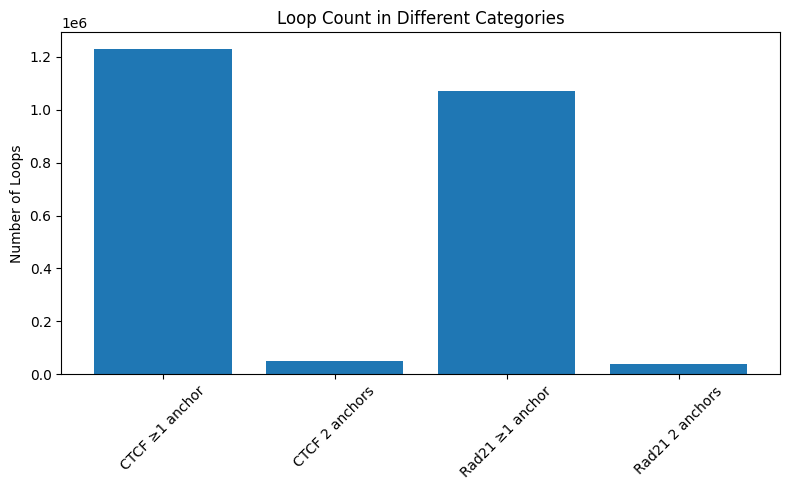

[INFO] Bar plot saved to: plot_basic.png


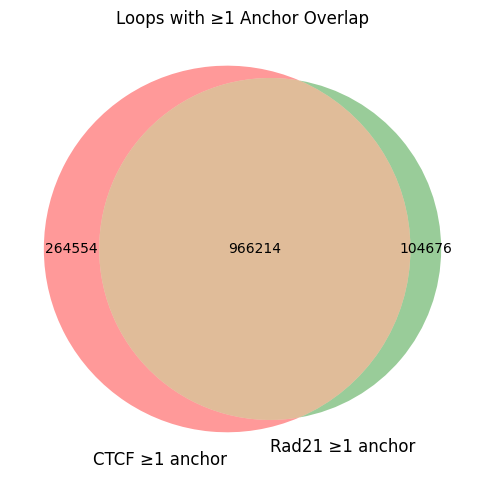

[INFO] Venn diagram saved to: plot_venn.png


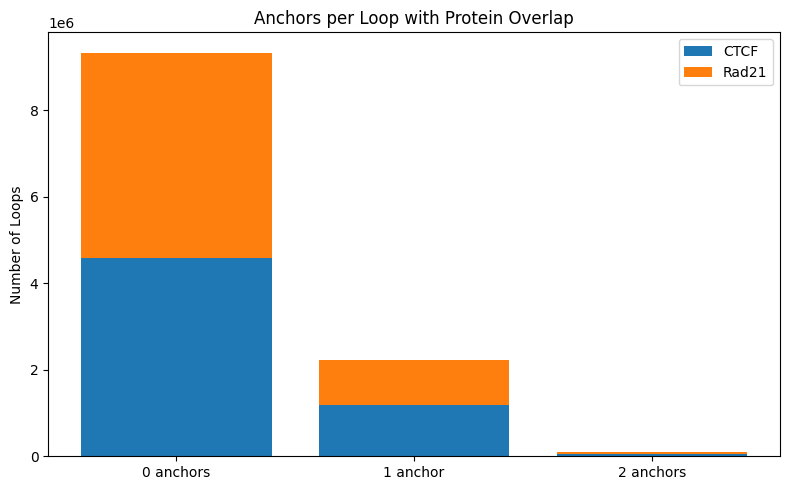

[INFO] Stacked bar chart saved to: plot_stacked.png


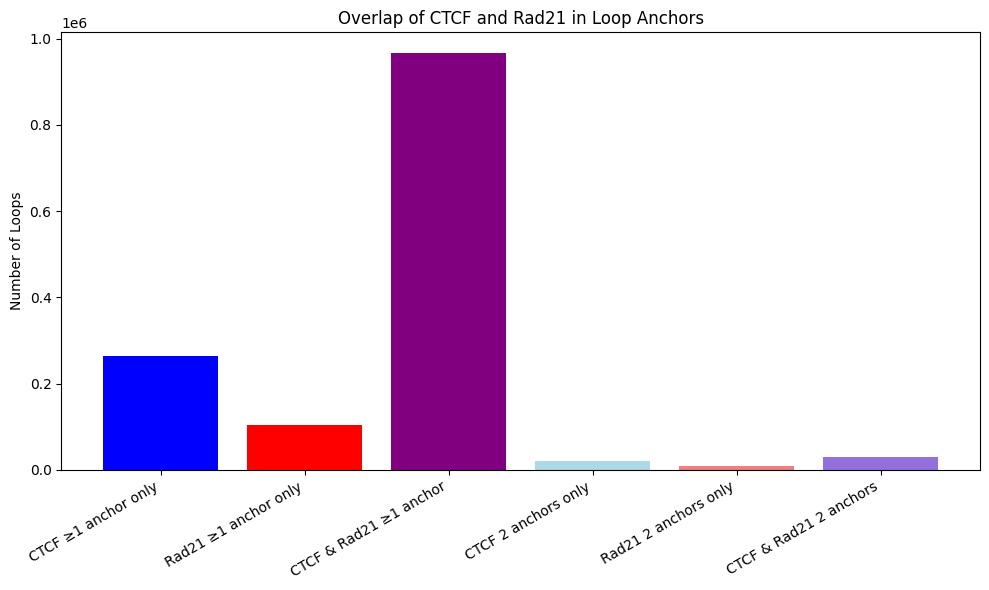

[INFO] Overlap comparison plot saved to: plot_overlap_summary.png
### [INFO] Analysis complete. ###


In [37]:
# Example: Run analysis on the first 1000 loops
process_chia_pet(
    chia_file=chia_pet_path,
    ctcf_file=ctcf_path,
    rad21_file=rad21_path,
    start=0,
    stop=None,
    out_csv="chia_pet_annotated_small.csv",
    out_plot="loop_categories_barplot_small.png"
)


## 5. Analysis Results

After running the filtering function on the ChIA-PET dataset (GM12878 cell line), we obtained the following:

### Console Statistics:
- **Total number of loops analyzed**: 5,815,083
- **Loops with ≥1 anchor overlapping a CTCF peak**: 1,230,768
- **Loops with both anchors overlapping CTCF peaks**: 49,905
- **Loops with ≥1 anchor overlapping a Rad21 peak**: 1,070,890
- **Loops with both anchors overlapping Rad21 peaks**: 37,902
- **Loops with ≥1 anchor overlapping both CTCF and Rad21**: 966,214
- **Loops with both anchors overlapping both CTCF and Rad21**: 29,179

---

### Annotated CSV Output:
The results were saved to a file like `chia_pet_annotated_small.csv`, which includes four new Boolean columns for each loop:
- `CTCF_1anchor`: `True` if at least one anchor overlaps a CTCF peak
- `CTCF_2anchors`: `True` if both anchors overlap CTCF peaks
- `Rad21_1anchor`: `True` if at least one anchor overlaps a Rad21 peak
- `Rad21_2anchors`: `True` if both anchors overlap Rad21 peaks

---

### Visual Outputs:
Several plots were generated to illustrate the distributions and overlaps:
- **Bar plot of loop counts**: `loop_categories_barplot_small.png`
- **Venn diagram of ≥1 anchor overlaps**: `plot_venn.png`
- **Stacked bar plot by number of protein-bound anchors**: `plot_stacked.png`
- **Comparison of overlapping categories (CTCF vs Rad21)**: `plot_overlap_summary.png`

---


You can visualize the output CSV or re-load it like this:


In [6]:
# Optional: Preview output file
annotated_df = pd.read_csv("chia_pet_annotated_small.csv")
annotated_df.head()

,chrom1,start1,end1,chrom2,start2,end2,CTCF_1anchor,CTCF_2anchors,Rad21_1anchor,Rad21_2anchors
0,chr10,49043,49694,chr10,1596907,1597444,False,False,False,False
1,chr10,49291,49814,chr10,71061105,71061664,False,False,False,False
2,chr10,50096,50747,chr10,19437275,19437902,False,False,False,False
3,chr10,52377,52917,chr10,78536,79151,False,False,False,False
4,chr10,52428,53079,chr10,806777,807334,False,False,False,False


## Example Region Visualization (pyGenomeTracks)

Below is a snapshot of the genomic region `chr1:1000000-2000000` showing:

- CTCF ChIP-seq peaks,
- Rad21 ChIP-seq peaks,
- ChIA-PET loops.

The visualization was generated using `pyGenomeTracks` and includes all relevant tracks defined in a configuration file (`tracks.ini`).


In [22]:
import subprocess

subprocess.run([
    "/home/kubog/.virtualenvs/GenomicsProject1/bin/pyGenomeTracks",
    "--tracks", "tracks.ini",
    "--region", "chr1:1200000-1300000",
    "--outFileName", "example_region_tracks.png"
])



INFO:pygenometracks.tracksClass:initialize 1. [x-axis]
INFO:pygenometracks.tracksClass:initialize 2. [spacer]
INFO:pygenometracks.tracksClass:initialize 3. [ctcf_peaks]
Value: 13.94962 in field 7 is not an integer
 Only the first 6 fields will be used.
100%|██████████| 13/13 [00:00<00:00, 45743.25it/s]
INFO:pygenometracks.tracksClass:initialize 4. [rad21_peaks]
Value: 95.29979 in field 7 is not an integer
 Only the first 6 fields will be used.
100%|██████████| 6/6 [00:00<00:00, 39016.78it/s]
INFO:pygenometracks.tracksClass:initialize 5. [chia_pet_loops]
100%|██████████| 554317/554317 [00:14<00:00, 37170.48it/s]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:17.826783657073975
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 10.106382978723405. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [x-axis]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [ctcf_peaks]
DEBUG:pyge

CompletedProcess(args=['/home/kubog/.virtualenvs/GenomicsProject1/bin/pyGenomeTracks', '--tracks', 'tracks.ini', '--region', 'chr1:1200000-1300000', '--outFileName', 'example_region_tracks.png'], returncode=0)

### Visualization Output

The plot below shows loop anchors and binding sites in the selected region.

![pyGenomeTracks example region](example_region_tracks.png)


## 6. Conclusions and Biological Interpretation

### Quantitative Insights:
- A large number of loops contain **at least one anchor** bound by **CTCF (1.23M)** or **Rad21 (1.07M)**.
- Far fewer loops have **both anchors** bound by either protein: ~50k for CTCF, ~38k for Rad21.
- **966,214 loops** share at least one anchor with both proteins, indicating a substantial degree of overlap and potential cooperation between CTCF and Rad21.
- A smaller subset (**29,179 loops**) shows co-binding of **both proteins at both anchors**, which may reflect the most stable and functional chromatin loops.

---

### Biological Significance:
- **CTCF** is a key architectural protein that acts as an insulator and plays a critical role in defining **TAD boundaries** (Topologically Associating Domains).
- **Rad21**, a component of the **cohesin complex**, is involved in **loop extrusion**, a process that stabilizes chromatin loops during gene regulation.
- Loops co-bound by CTCF and Rad21 are likely to represent **structural loops** critical for **chromatin organization** and **gene expression control**.
- The relatively low number of loops with both anchors bound by both proteins may reflect:
  - The selectivity and functional importance of these loops,
  - Experimental limitations in detecting simultaneous ChIP-seq signals for both proteins.

---


## 7. Requirements & How to Run

### Python Package Requirements (example versions):

- `python >= 3.8`
- `pandas >= 1.4.0`
- `pyranges >= 0.0.115`
- `matplotlib >= 3.5.0`

### Installation

Install the required packages using `pip`:

```bash
pip install pandas pyranges matplotlib
